## Number classifier task

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def extract_data(path):
    """Load data file"""
    return np.loadtxt(path, dtype=np.int16, delimiter=',')

def reshape_matrix(mat):
    """Reshape each line in the matrix into a quadratic image"""
    reshapedMat = []
    
    for i in range(np.size(mat,0)):
        reshapedMat.append(mat[i,:].reshape(28,28))

    return np.array(reshapedMat)

def nn(data_to_be_classified, labeled_data):
    n_samples = data_to_be_classified.shape[0]
    block_size = 500
    nn_idx = np.zeros(n_samples, dtype=int)

    for i in range(0, n_samples, block_size):

        distance = scipy.spatial.distance.cdist(data_to_be_classified[i:i+block_size], labeled_data, metric="euclidean")
        nn_idx[i:i+block_size] = np.argmin(distance, axis=1)

    return nn_idx


In [5]:
# Extract data from csv files

trainv = extract_data("numbers_data/trainv.csv")  
testv = extract_data("numbers_data/testv.csv")
trainlab = extract_data("numbers_data/trainlab.csv")
testlab = extract_data("numbers_data/testlab.csv")

### Classify all samples using NN

In [4]:
# Calculate results of inly NN
nn_idx = nn(testv, trainv)

np.savetxt("pred_no_cluster.txt", nn_idx, fmt="%.d")

nn_pred = trainlab[nn_idx]
correct_predictions = (testlab == nn_pred)
print(sum(correct_predictions)/1e4)

NameError: name 'testv' is not defined

##### Confusion matrix and error rates

0: classifier has error rate 0.02014098690835851 (20 errors, 993 samples)
1: classifier has error rate 0.032562125107112254 (38 errors, 1167 samples)
2: classifier has error rate 0.015873015873015872 (16 errors, 1008 samples)
3: classifier has error rate 0.03865213082259663 (39 errors, 1009 samples)
4: classifier has error rate 0.027806385169927908 (27 errors, 971 samples)
5: classifier has error rate 0.048672566371681415 (44 errors, 904 samples)
6: classifier has error rate 0.018711018711018712 (18 errors, 962 samples)
7: classifier has error rate 0.04339440694310511 (45 errors, 1037 samples)
8: classifier has error rate 0.019189765458422176 (18 errors, 938 samples)
9: classifier has error rate 0.043521266073194856 (44 errors, 1011 samples)


Text(0.5, 1.0, 'NN-classifier with no clustering')

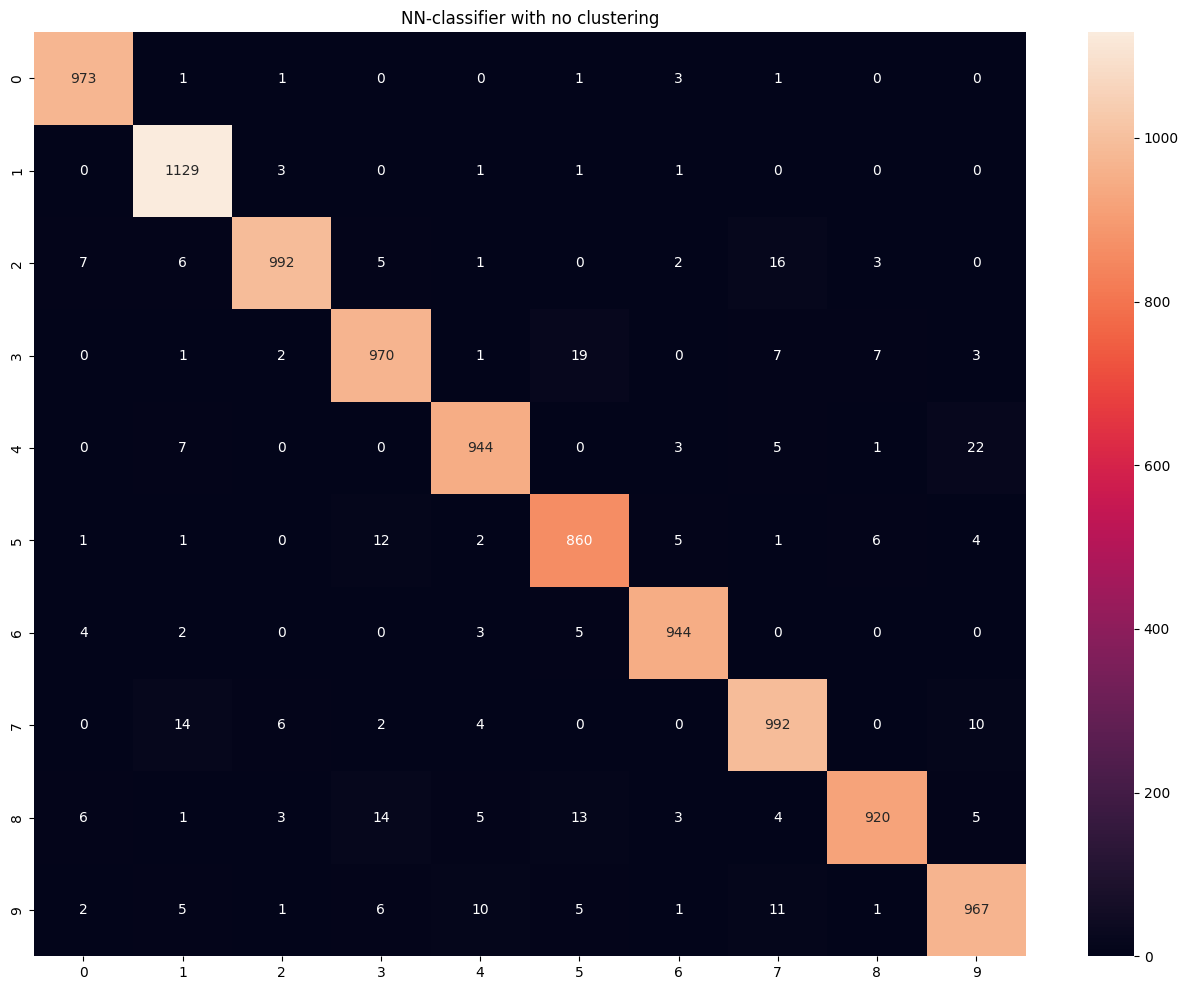

In [8]:
import seaborn as sn

# set starting value of all counters to 0
prediction_dict = {i: [0,0,0] for i in range(10)}
confMatrix = np.zeros((10,10))

correct_predictions_idx = []
false_predictions_idx = []

for i in range(np.size(testlab)):
    # create confusion matrix
    confMatrix[testlab[i]][nn_pred[i]] += 1
    # count how many times this number is in the dataset
    prediction_dict[nn_pred[i]][0] += 1
    
    if correct_predictions[i]:
    # count how many times this number has been correctly classified
        prediction_dict[nn_pred[i]][1] += 1
    # add correct prediction index to list
        correct_predictions_idx.append([i, nn_pred[i]])
    else:
    # count how many times it has been incorrectly classified
        prediction_dict[nn_pred[i]][2] += 1
    # add incorrect prediction to list
        false_predictions_idx.append([i, nn_pred[i]])

for i in range(10):
    print(f"{i}: classifier has error rate {prediction_dict[i][2]/prediction_dict[i][0]} ({prediction_dict[i][2]} errors, {prediction_dict[i][0]} samples)")

plt.figure(figsize = (16,12))
sn.heatmap(confMatrix, annot=True, fmt='.4g').set_title('NN-classifier with no clustering')
    

##### Some correctly classified and missclassified images

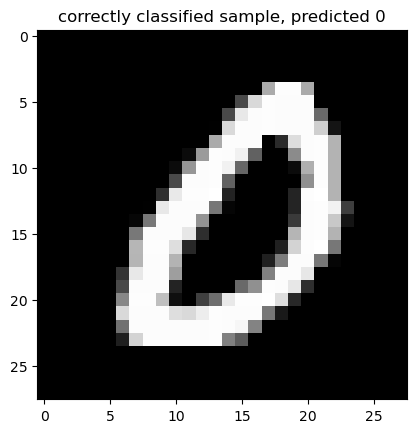

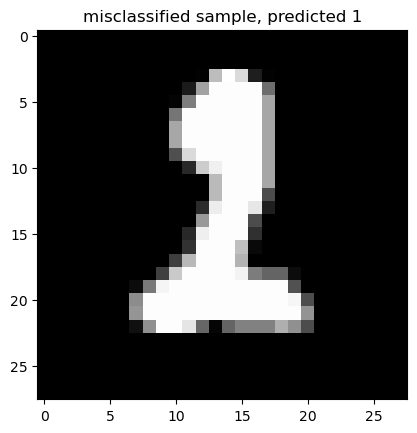

In [ ]:
# Reshaped data contains images
reshapedTrainv = reshape_matrix(trainv)
reshapedTestv = reshape_matrix(testv)

num_samples = 1
np.random.seed(42)

for i in range(num_samples):
    random_correct_idx = np.random.randint(0,np.size(correct_predictions_idx, 0))
    random_false_idx = np.random.randint(0,np.size(false_predictions_idx, 0))
    
    plt.figure(i)
    plt.imshow(reshapedTestv[correct_predictions_idx[random_correct_idx][0]], cmap='gray')
    plt.title(f"correctly classified sample, predicted {correct_predictions_idx[random_correct_idx][1]}")
    
    plt.figure(i+num_samples)
    plt.imshow(reshapedTestv[false_predictions_idx[random_false_idx][0]], cmap='gray')
    plt.title(f"misclassified sample, predicted {false_predictions_idx[random_false_idx][1]}")


#### KNN-Classifier with K-means clustering

In [44]:
def k_means(data, k, max_iterations):
    # form k initial centroids
    np.random.seed(42)
    centroids = np.random.uniform(0, 255, (k, 784))
    
    iteration = 0

    while iteration < max_iterations:
        
        # For each sample in data, calculate the distance to each centroid
        distance_to_centroids = scipy.spatial.distance.cdist(data, centroids, metric='euclidean')
        # Assign each sample to the closest centroid
        cluster_idxs = np.argmin(distance_to_centroids, axis=1)
        
        # Iterate over each cluster
        for i in range(k):
            # Get all the datapoints belonging to this cluster
            cluster_data = data[cluster_idxs == i]
            if len(cluster_data > 0):
                centroids[i] = np.mean(cluster_data, axis=0)

        iteration += 1
    
    return centroids

In [45]:
# Sort data by class
trainv_by_class = []
for i in range(10):
    trainv_by_class.append(trainv[trainlab == i])

# Create M clusters for each class, run for N iterations
M = 64
N = 20
centroids = np.zeros((M*10, 784))

for i in range(10):
    centroids_class = k_means(data=trainv_by_class[i], k=M, max_iterations=N)
    centroids[i*M:(i+1)*M] = centroids_class      # Add centroids

# Create labels for centroids
centroids_lab = np.zeros(M*10)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M


nn_idx = nn(data_to_be_classified=testv, labeled_data=centroids)

predictions = centroids_lab[nn_idx]
correct_predictions = (testlab == predictions)
print("Result")
print(sum(correct_predictions)/1e4)

Result
0.9383


#### Sklearn kmeans algorithm (NP-hard problem to solve)

In [28]:
import sklearn.cluster as sk

# Sort data by class
trainv_by_class = []
for i in range(10):
    trainv_by_class.append(trainv[trainlab == i])

# Create M clusters for each class, run for N iterations
M = 64
centroids = np.zeros((M*10, 784))

for i in range(10):
    kmeans = sk.KMeans(n_clusters=M, random_state=42)
    kmeans.fit_predict(trainv_by_class[i])  # Cluster data
    centroids_class = kmeans.cluster_centers_     # Get centroids
    centroids[i*M:(i+1)*M] = centroids_class      # Add centroids

# Create labels for centroids
centroids_lab = np.zeros(M*10)
for i in range(10):
    centroids_lab[i*M:(i+1)*M] = [i]*M


nn_idx = nn(data_to_be_classified=testv, labeled_data=centroids)

predictions = centroids_lab[nn_idx]
correct_predictions = (testlab == predictions)
print("Result")
print(sum(correct_predictions)/1e4)

Result
0.9523
